In [ ]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))  # 0 indicates the GPU device number
else:
    device = torch.device("cpu")
    print("GPU is not available")


GPU is available
Device name: Tesla T4


In [ ]:
!nvidia-smi

Sat Jun 10 13:39:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    50W / 350W |   4033MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!unzip '/content/drive/MyDrive/Affecnetmask.zip' -d '/content/drive/MyDrive/Affecnetmask'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0026782_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0027282_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0021341_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0024411_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0030262_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0008361_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0001294_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0029090_surgical.jpg  
  inflating: /content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked/image0005091_surgical.jpg  
  inflating: /content/drive/MyDrive/Affe

## Data Description

### FER2013

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-12 11:18:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-12 11:18:52 (61.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
#path of the data
data_path = '/content/drive/MyDrive/Affecnetmask/Affecnetmask'
train_dir = os.path.join(data_path, '/content/drive/MyDrive/Affecnetmask/Affecnetmask')
walk_through_dir(train_dir)

There are 8 directories and 1 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask'.
There are 0 directories and 5030 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/happy_masked'.
There are 0 directories and 3901 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/surprise_masked'.
There are 0 directories and 2800 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/contempt_masked'.
There are 0 directories and 3038 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/anger_masked'.
There are 0 directories and 2985 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/fear_masked'.
There are 0 directories and 5093 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/neutral_masked'.
There are 0 directories and 2899 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/sad_masked'.
There are 0 directories and 2390 images in '/content/drive/MyDrive/Affecnetmask/Affecnetmask/disgust_masked'.


In [ ]:
#change the data image into csv
def convert_path_to_df(train_dir):
    image_dir = Path(train_dir)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(train_dir)

In [ ]:
# Load the image data
images = []
labels = []

# Iterate through the image files in the directory
for filename in os.listdir(train_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(train_dir, filename))
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image to a fixed size if needed
        # resized = cv2.resize(gray, (desired_width, desired_height))
        # Append the preprocessed image and label to the lists
        images.append(gray)
        label = int(filename.split('.')[0].split('_')[-1])  # Extract the label from the filename
        labels.append(label)

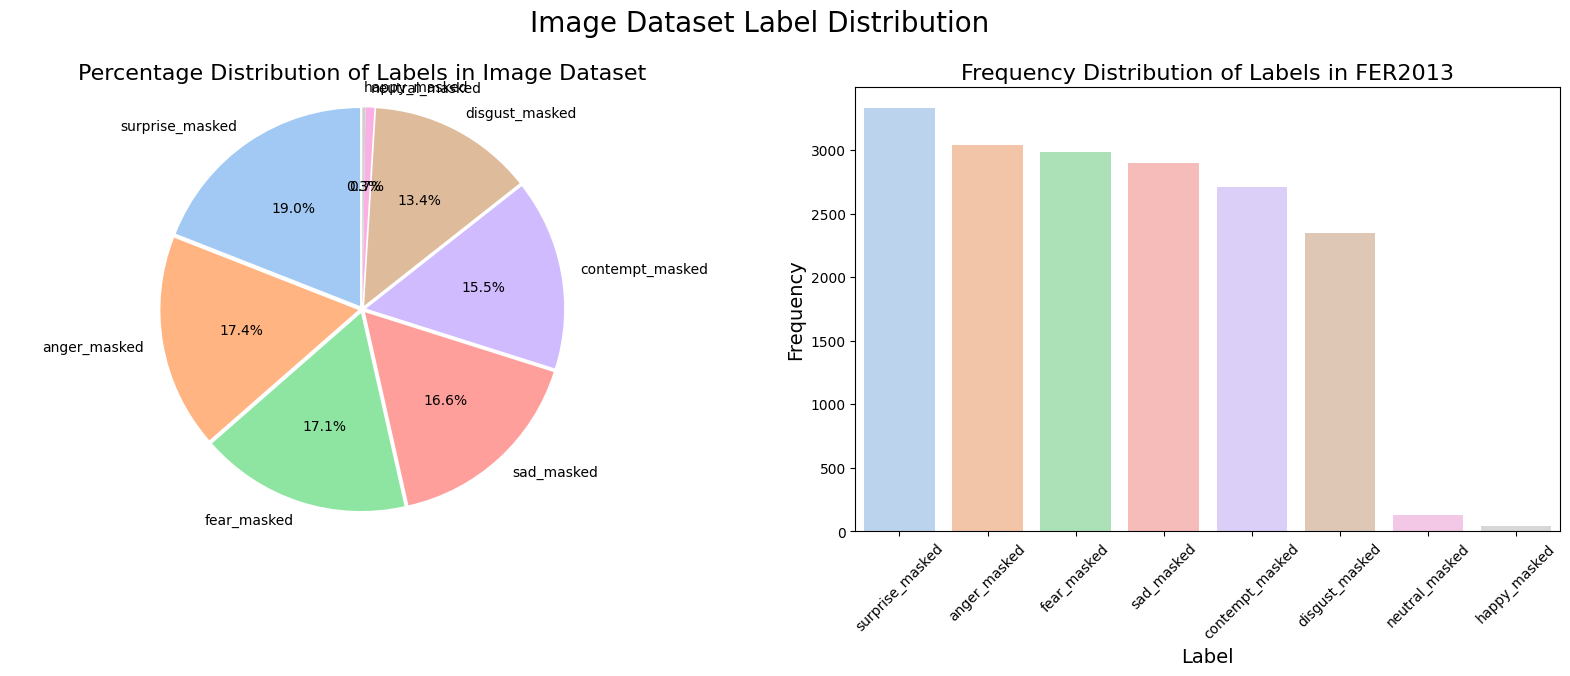

In [ ]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Define the color palette for the pie chart
colors = sns.color_palette('pastel', len(label_counts))
#colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#CC99FF', '#FFFF99', '#99FFFF']

# Plot the pie chart with percentages, colors, and separation
explode = [0.02] * len(label_counts)  # Define separation values for each pie slice
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axes[0].set_title('Percentage Distribution of Labels in Image Dataset', fontsize=16)

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes[1])
axes[1].set_title('Frequency Distribution of Labels in FER2013', fontsize=16)
axes[1].set_xlabel('Label', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

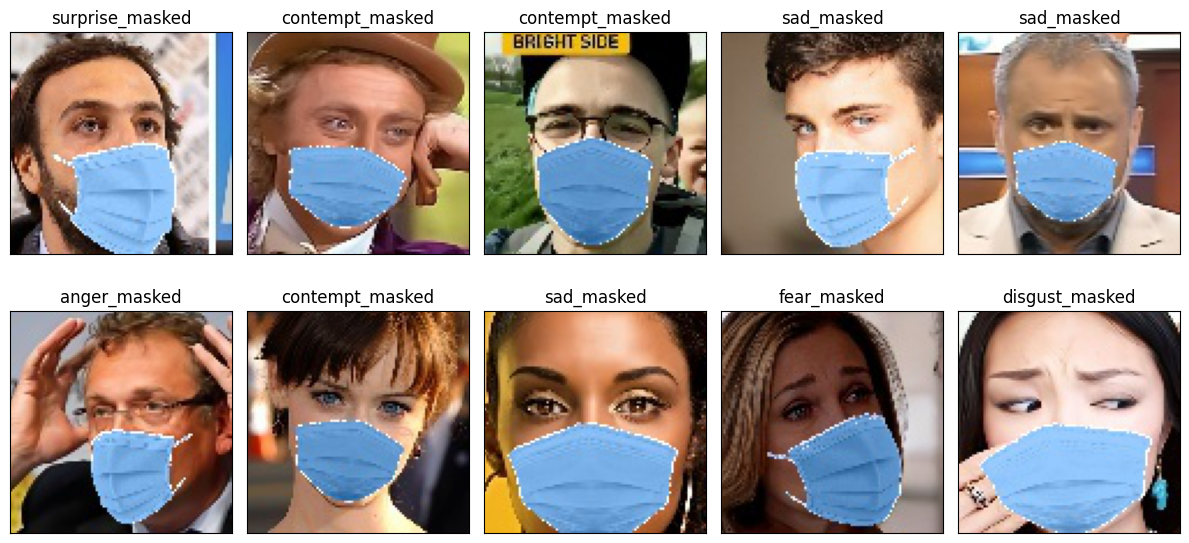

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(image_df), 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])

plt.tight_layout()
plt.show()


### LFW

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#path of the data
data_path = '/content/drive/MyDrive/LFWMask'
train_dir = os.path.join(data_path, '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train')
walk_through_dir(train_dir)

There are 3 directories and 0 images in '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train'.
There are 0 directories and 799 images in '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train/negative'.
There are 0 directories and 3547 images in '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train/neutral'.
There are 0 directories and 5479 images in '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train/positive'.


In [ ]:
#change the data image into csv
def convert_path_to_df(train_dir):
    image_dir = Path(train_dir)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(train_dir)

In [ ]:
# Load the image data
images = []
labels = []

# Iterate through the image files in the directory
for filename in os.listdir(train_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Load the image
        image = cv2.imread(os.path.join(train_dir, filename))
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize the image to a fixed size if needed
        # resized = cv2.resize(gray, (desired_width, desired_height))
        # Append the preprocessed image and label to the lists
        images.append(gray)
        label = int(filename.split('.')[0].split('_')[-1])  # Extract the label from the filename
        labels.append(label)

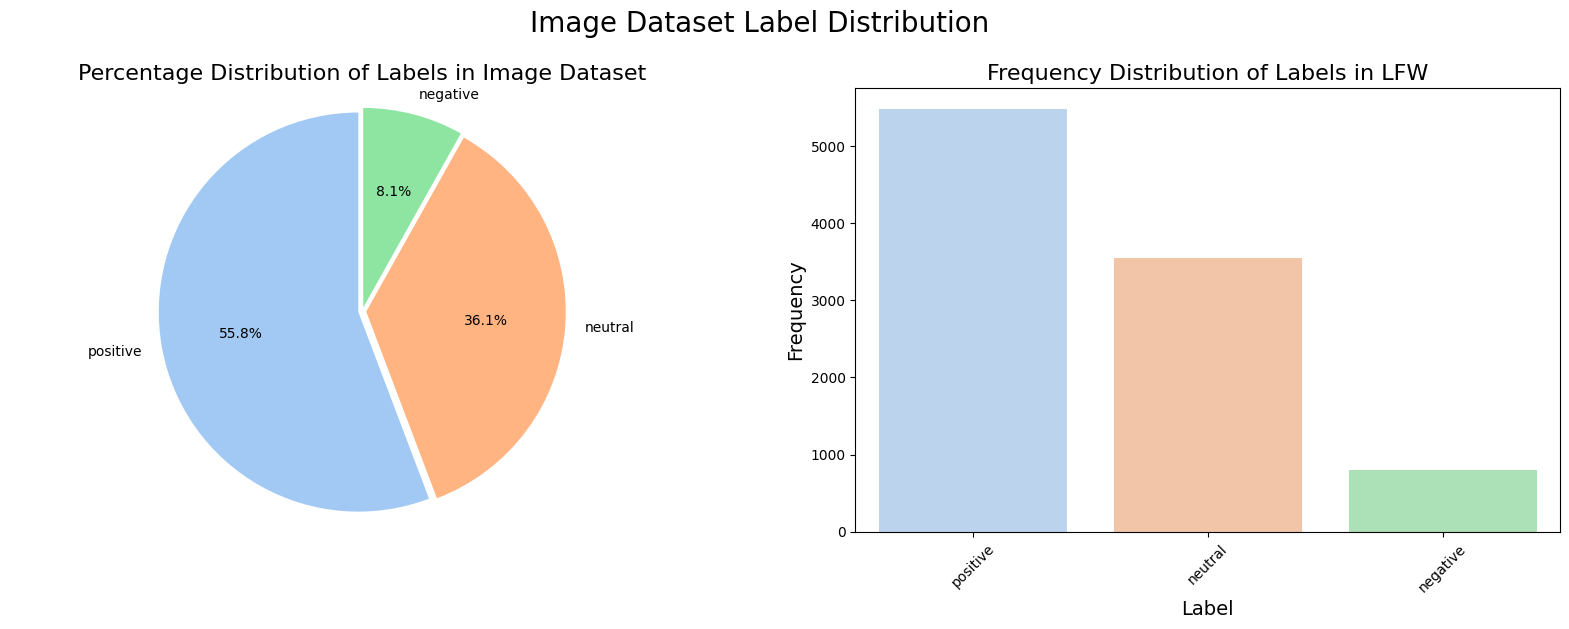

In [ ]:
# Get the value counts for each label
label_counts = image_df['Label'].value_counts()

# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Define the color palette for the pie chart
colors = sns.color_palette('pastel', len(label_counts))
#colors=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#CC99FF', '#FFFF99', '#99FFFF']

# Plot the pie chart with percentages, colors, and separation
explode = [0.02] * len(label_counts)  # Define separation values for each pie slice
axes[0].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
axes[0].axis('equal')  # Equal aspect ratio ensures the pie chart is circular
axes[0].set_title('Percentage Distribution of Labels in Image Dataset', fontsize=16)

# Plot the bar chart
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='pastel', ax=axes[1])
axes[1].set_title('Frequency Distribution of Labels in LFW', fontsize=16)
axes[1].set_xlabel('Label', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].set_xticklabels(label_counts.index, rotation=45)

# Add a super-title to the figure
fig.suptitle('Image Dataset Label Distribution', fontsize=20)

# Adjust the spacing between the plots and the title
fig.subplots_adjust(top=0.85)

# Display the plot
plt.show()

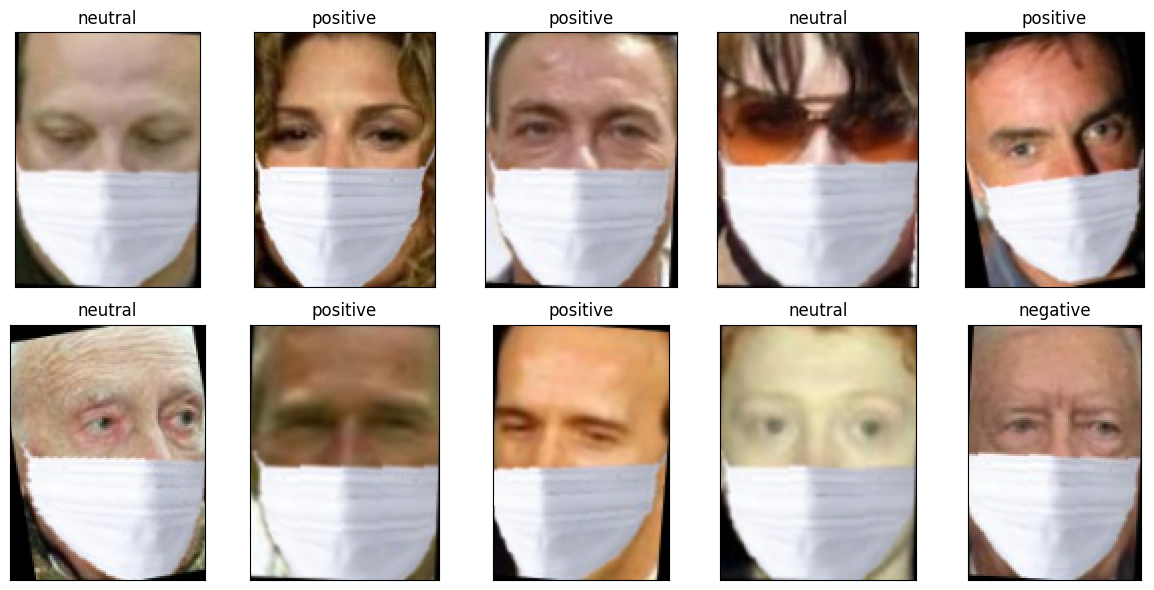

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

random_index = np.random.randint(0, len(image_df), 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])

plt.tight_layout()
plt.show()


## **DEEP LEARNING CNN**

## FER-2013 Dataset

*** ***

In [ ]:
#import necessary libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

#from tensorflow.keras.utils import load_img

### CNN General Architecture

In [ ]:
img_shape = 36
batch_size = 64
data_path = '/content/drive/MyDrive/data_path'

train_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/train')
test_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/validation')

In [ ]:
# Define data augmentation parameters

train_datagen = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_datagen = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 15531 images belonging to 7 classes.
Found 4953 images belonging to 7 classes.


Found 15531 images belonging to 7 classes.


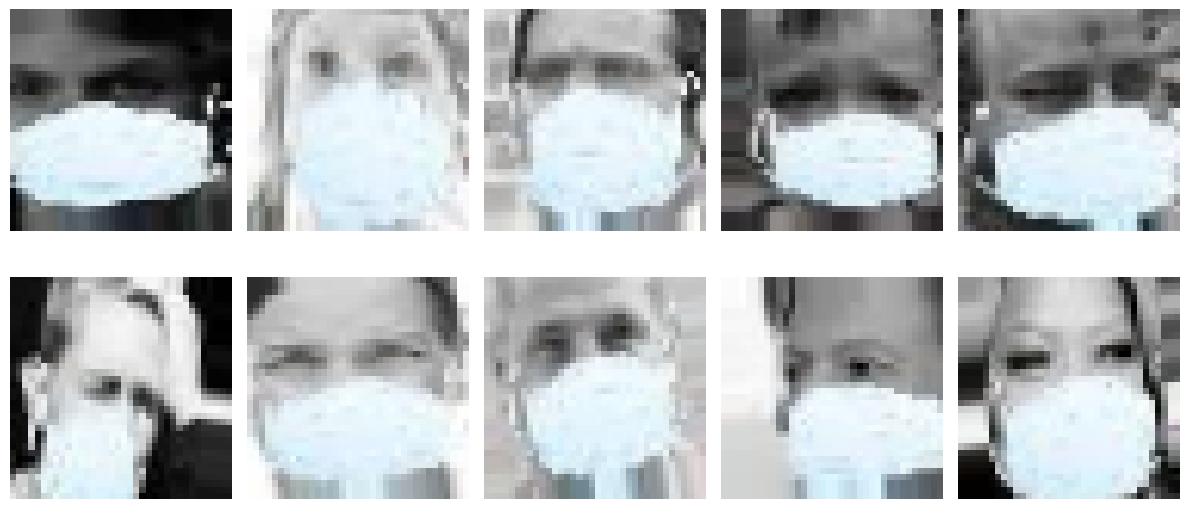

In [ ]:
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images = train_datagen.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

# Visualize augmented images
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

for i in range(10):
    image = augmented_images.next()[0][0]  # Get the first augmented image
    axs[i].imshow(image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#3 convolutional layers
from keras.layers import BatchNormalization

def CNN_model():
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(7,activation='softmax'))

    return model


In [ ]:
#4 convolutional layer
from keras.layers import BatchNormalization

def CNN_model():
    model = Sequential()

    model.add(Conv2D(64, (3,3), activation='relu', input_shape=(img_shape, img_shape, 3)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
from keras.layers import LeakyReLU

def CNN_model():
    model = Sequential()

    model.add(Conv2D(64, (3,3), input_shape=(48, 48, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(3,3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256,(3,3)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))

    return model


In [ ]:
CNN_Model = CNN_model()
CNN_Model.summary()
CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 34, 34, 64)        1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_15 (Bat  (None, 17, 17, 64)       256       
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 17, 17, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 128)       

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
CNN_history = CNN_Model.fit(train_data , validation_data= test_data,
                            epochs=20, batch_size= 36,
                            callbacks=callbacks,
                            steps_per_epoch= steps_per_epoch,
                            validation_steps=validation_steps)

Epoch 1/20
242/242 [==============================] - 39s 139ms/step - loss: 2.3723 - accuracy: 0.1894 - val_loss: 2.1245 - val_accuracy: 0.1155 - lr: 0.0010
Epoch 2/20
242/242 [==============================] - 33s 137ms/step - loss: 1.9854 - accuracy: 0.2136 - val_loss: 1.9222 - val_accuracy: 0.1593 - lr: 0.0010
Epoch 3/20
242/242 [==============================] - 34s 140ms/step - loss: 1.8810 - accuracy: 0.2370 - val_loss: 2.1042 - val_accuracy: 0.1660 - lr: 0.0010
Epoch 4/20
242/242 [==============================] - ETA: 0s - loss: 1.8300 - accuracy: 0.2538
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
242/242 [==============================] - 33s 137ms/step - loss: 1.8300 - accuracy: 0.2538 - val_loss: 2.2925 - val_accuracy: 0.1678 - lr: 0.0010
Epoch 5/20
242/242 [==============================] - 34s 138ms/step - loss: 1.7816 - accuracy: 0.2669 - val_loss: 1.9921 - val_accuracy: 0.1897 - lr: 2.0000e-04
Epoch 6/20
242/242 [========================

In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

78/78 [==============================] - 6s 71ms/step - loss: 1.9346 - accuracy: 0.2174
    Test Loss: 1.93459
Test Accuracy: 21.74%


In [ ]:
def plot_model(history):

    epochs = range(len(history.history["loss"]))

    # Plot the training and validation loss
    plt.figure(figsize=(15,5))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


<Figure size 1500x500 with 0 Axes>

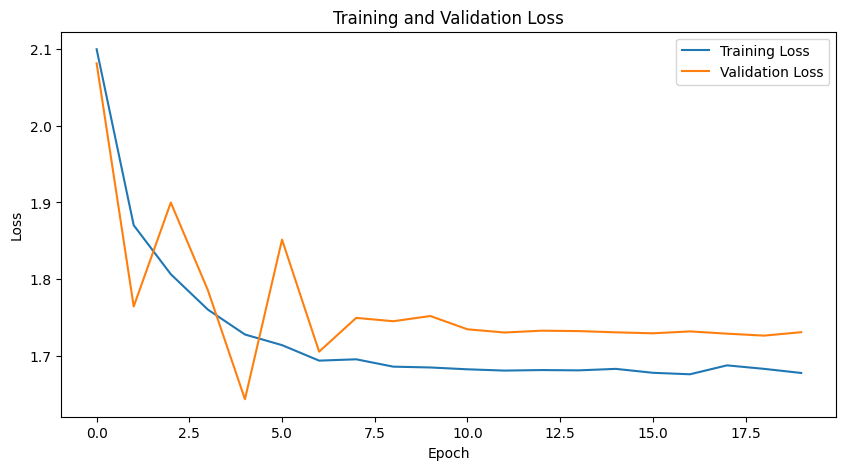

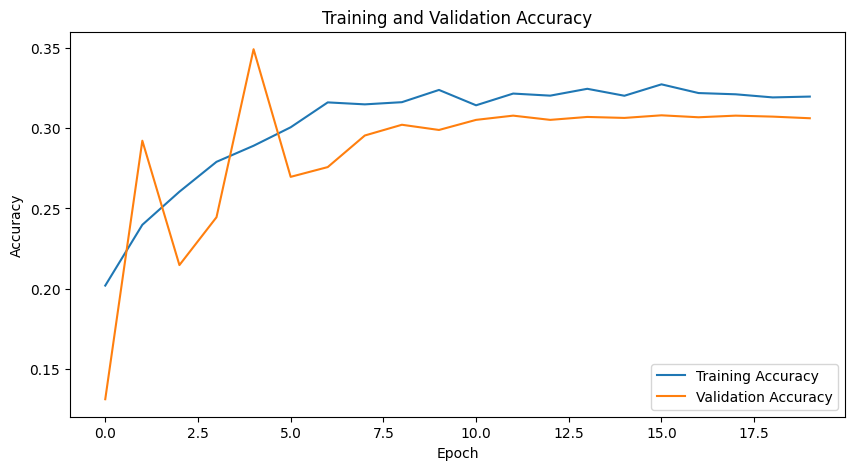

None


In [ ]:
print(plot_model(CNN_history))

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

78/78 [==============================] - 11s 137ms/step


In [ ]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

Text(0.5, 1.0, 'CNN Confusion Matrix')

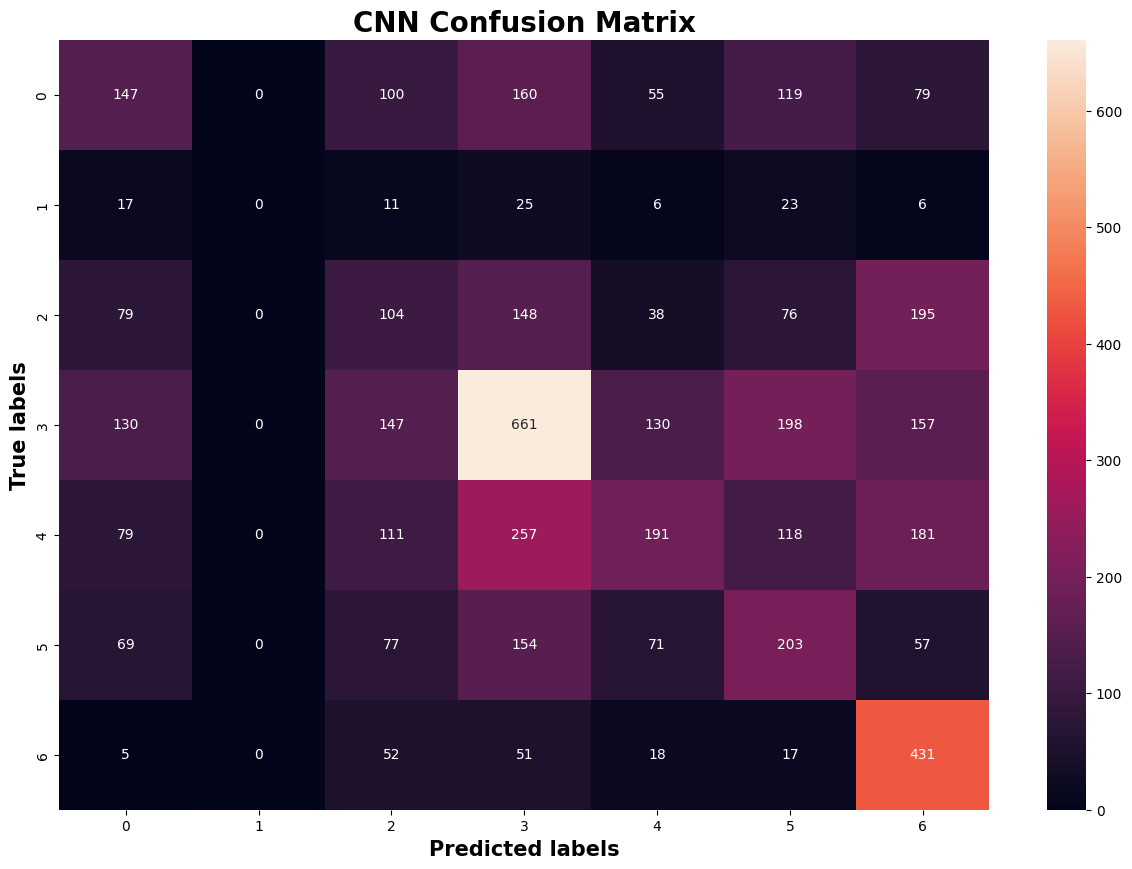

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [ ]:
# Print classification report and confusion matrix
print('Classification report:')
print(classification_report(test_data.labels, CNN_Predictions))

Classification report:
              precision    recall  f1-score   support

           0       0.28      0.22      0.25       660
           1       0.00      0.00      0.00        88
           2       0.17      0.16      0.17       640
           3       0.45      0.46      0.46      1423
           4       0.38      0.20      0.26       937
           5       0.27      0.32      0.29       631
           6       0.39      0.75      0.51       574

    accuracy                           0.35      4953
   macro avg       0.28      0.30      0.28      4953
weighted avg       0.34      0.35      0.33      4953



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 4953 images belonging to 7 classes.


In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

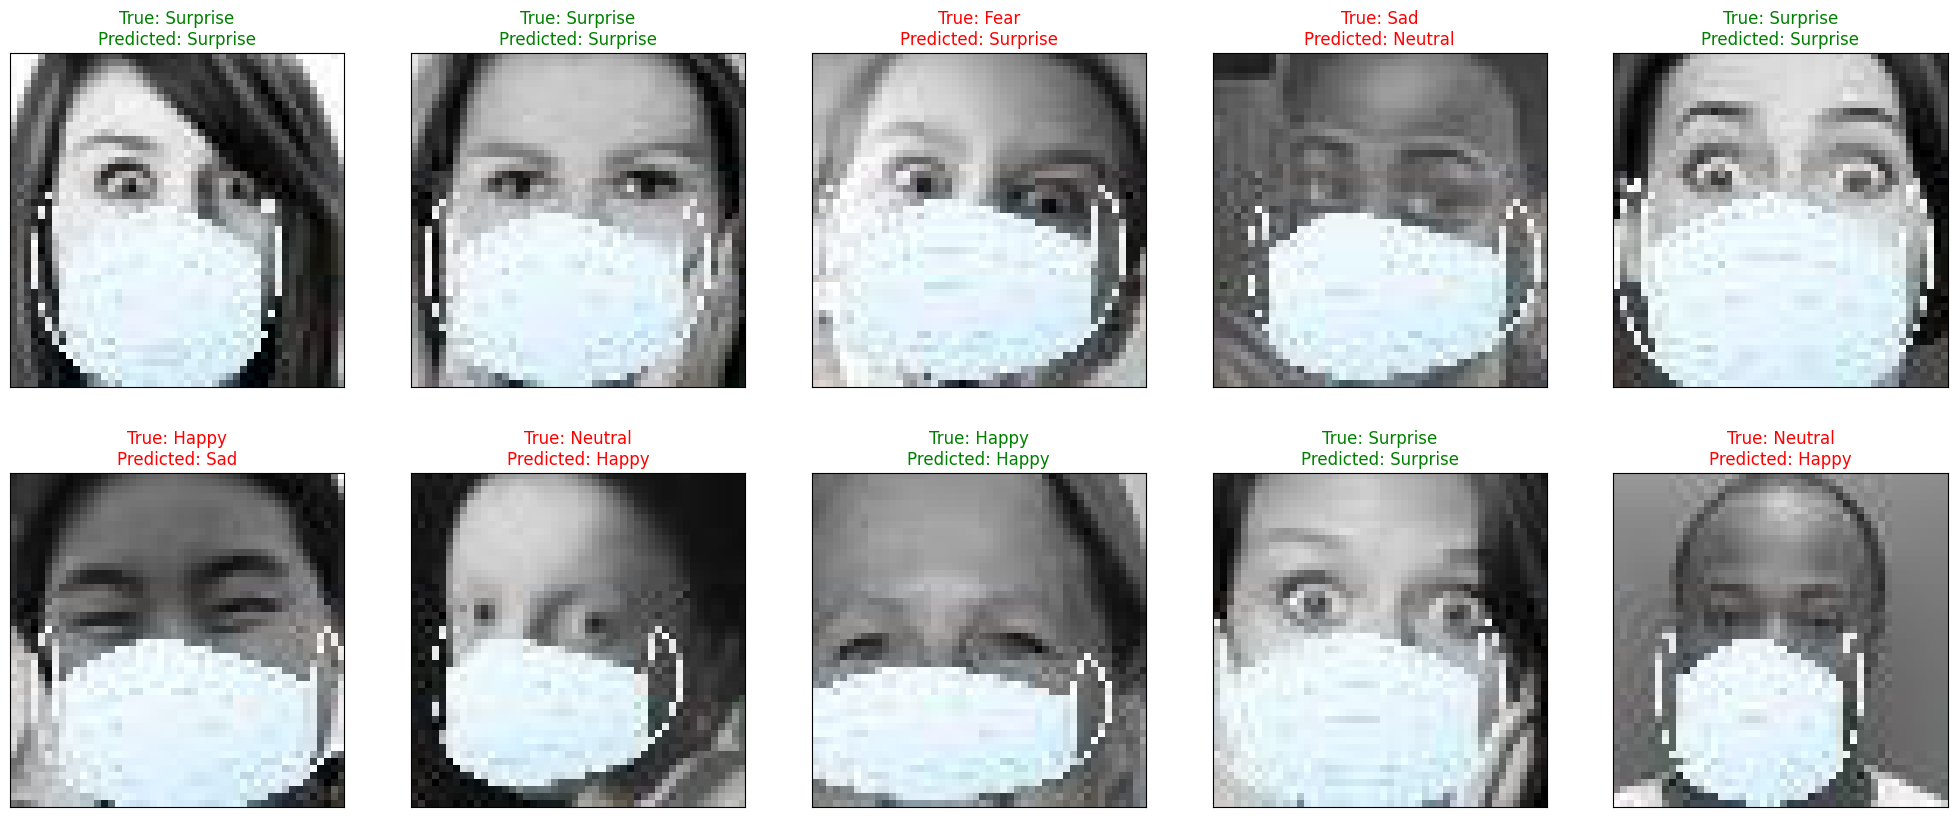

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


### RESNET50 FER Dataset

In [ ]:
img_shape = 224
batch_size = 64
data_path = '/content/data_path/masked-fer'

train_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/train')
test_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/validation')

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 15531 images belonging to 7 classes.
Found 4953 images belonging to 7 classes.


In [ ]:
# Fine-Tuning ResNet50V2
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras.layers import BatchNormalization

def Create_ResNet50V2_Model():
    model = Sequential([
                      ResNet50V2,
                      Dropout(.5),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_21 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_21 (Bat  (None, 7, 7, 2048)       8192      
 chNormalization)                                                
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 64)                6422592   
                                                                 
 batch_normalization_22 (Bat  (None, 64)               256       
 chNormalization)                                     

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                          callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
242/242 [==============================] - 196s 753ms/step - loss: 2.0415 - accuracy: 0.2776 - val_loss: 2.9070 - val_accuracy: 0.3032 - lr: 0.0010
Epoch 2/20
242/242 [==============================] - 181s 750ms/step - loss: 1.8035 - accuracy: 0.3391 - val_loss: 5.0247 - val_accuracy: 0.2646 - lr: 0.0010
Epoch 3/20
242/242 [==============================] - 181s 747ms/step - loss: 1.6911 - accuracy: 0.3737 - val_loss: 1.7043 - val_accuracy: 0.3880 - lr: 0.0010
Epoch 4/20
242/242 [==============================] - 182s 750ms/step - loss: 1.6109 - accuracy: 0.4033 - val_loss: 1.6106 - val_accuracy: 0.4351 - lr: 0.0010
Epoch 5/20
242/242 [==============================] - 181s 749ms/step - loss: 1.5251 - accuracy: 0.4296 - val_loss: 1.4915 - val_accuracy: 0.4491 - lr: 0.0010
Epoch 6/20
242/242 [==============================] - 179s 740ms/step - loss: 1.4908 - accuracy: 0.4395 - val_loss: 1.5113 - val_accuracy: 0.4361 - lr: 0.0010
Epoch 7/20
242/242 [==========================

In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

78/78 [==============================] - 11s 144ms/step - loss: 1.2842 - accuracy: 0.5320
    Test Loss: 1.28416
Test Accuracy: 53.20%


In [ ]:
def plot_model(history):

    epochs = range(len(history.history["loss"]))

    # Plot the training and validation loss
    plt.figure(figsize=(15,5))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss ResNet50V2')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy ResNet50V2')
    plt.legend()
    plt.show()


<Figure size 1500x500 with 0 Axes>

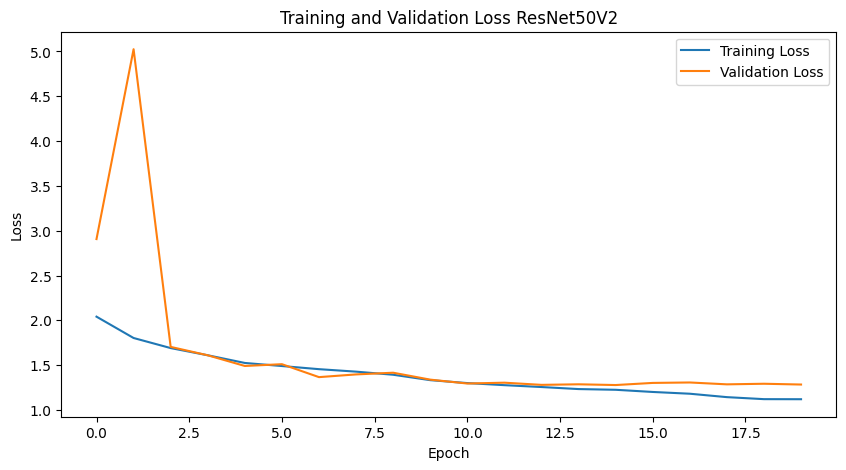

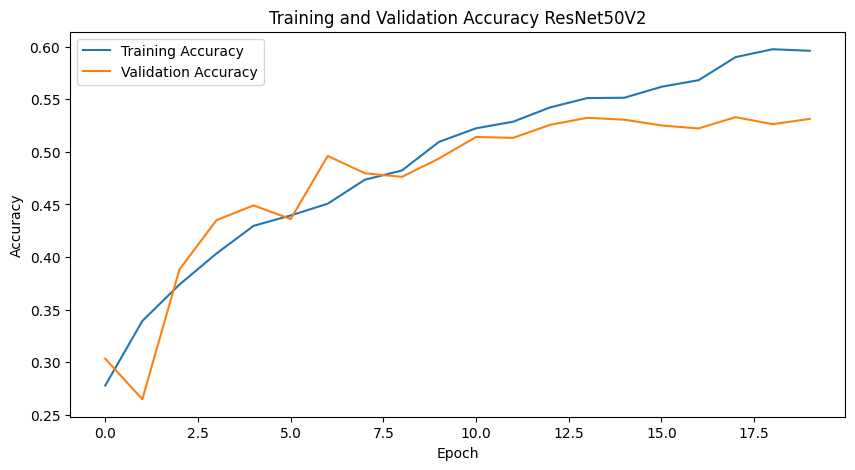

None


In [ ]:
print(plot_model(ResNet50V2_history))

In [ ]:
ResNet50_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50_Predictions = np.argmax(ResNet50_Predictions, axis=1)

78/78 [==============================] - 11s 135ms/step


In [ ]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

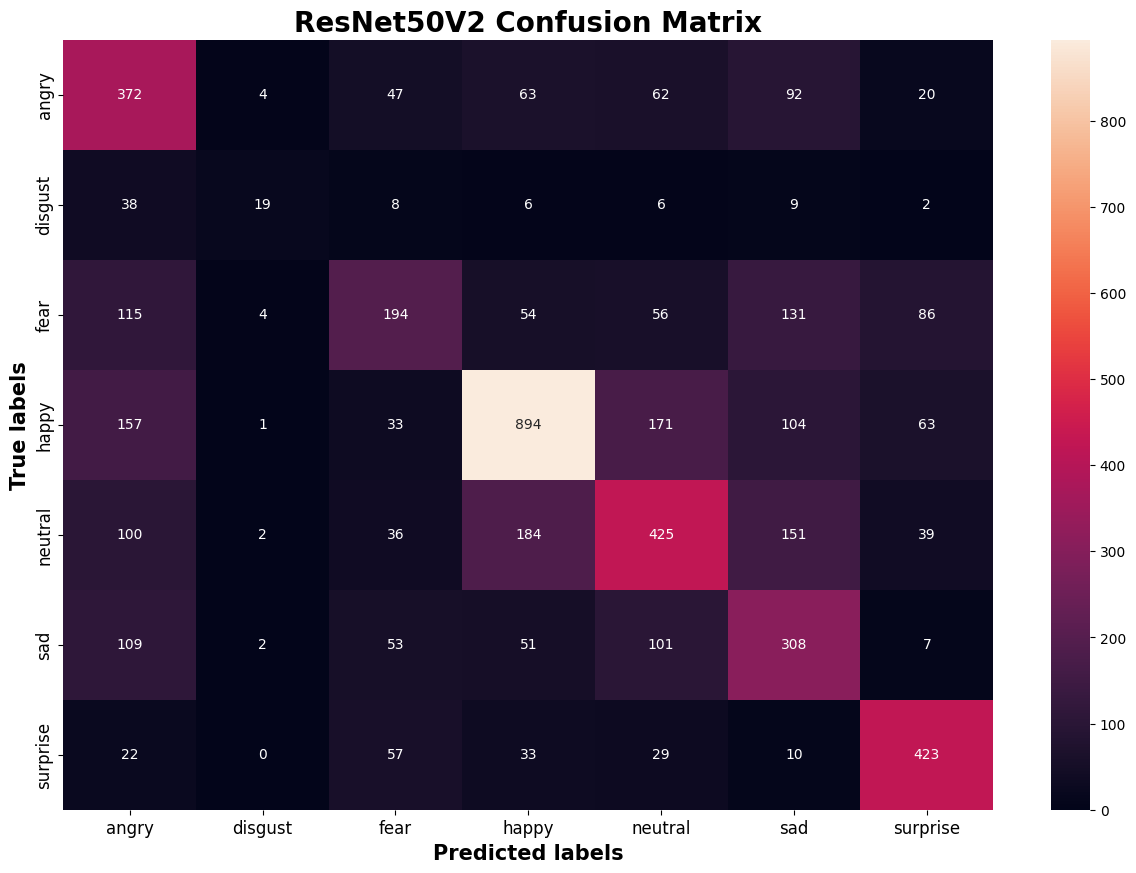

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 10))

class_names = test_data.class_indices

cm = confusion_matrix(test_data.labels, ResNet50_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xticklabels(class_names, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

plt.show()


In [ ]:
test_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
# Print classification report and confusion matrix

target_names = test_data.class_indices
print('Classification report:')
print(classification_report(test_data.labels, ResNet50_Predictions, target_names=target_names))


Classification report:
              precision    recall  f1-score   support

       angry       0.41      0.56      0.47       660
     disgust       0.59      0.22      0.32        88
        fear       0.45      0.30      0.36       640
       happy       0.70      0.63      0.66      1423
     neutral       0.50      0.45      0.48       937
         sad       0.38      0.49      0.43       631
    surprise       0.66      0.74      0.70       574

    accuracy                           0.53      4953
   macro avg       0.53      0.48      0.49      4953
weighted avg       0.54      0.53      0.53      4953



In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 4953 images belonging to 7 classes.


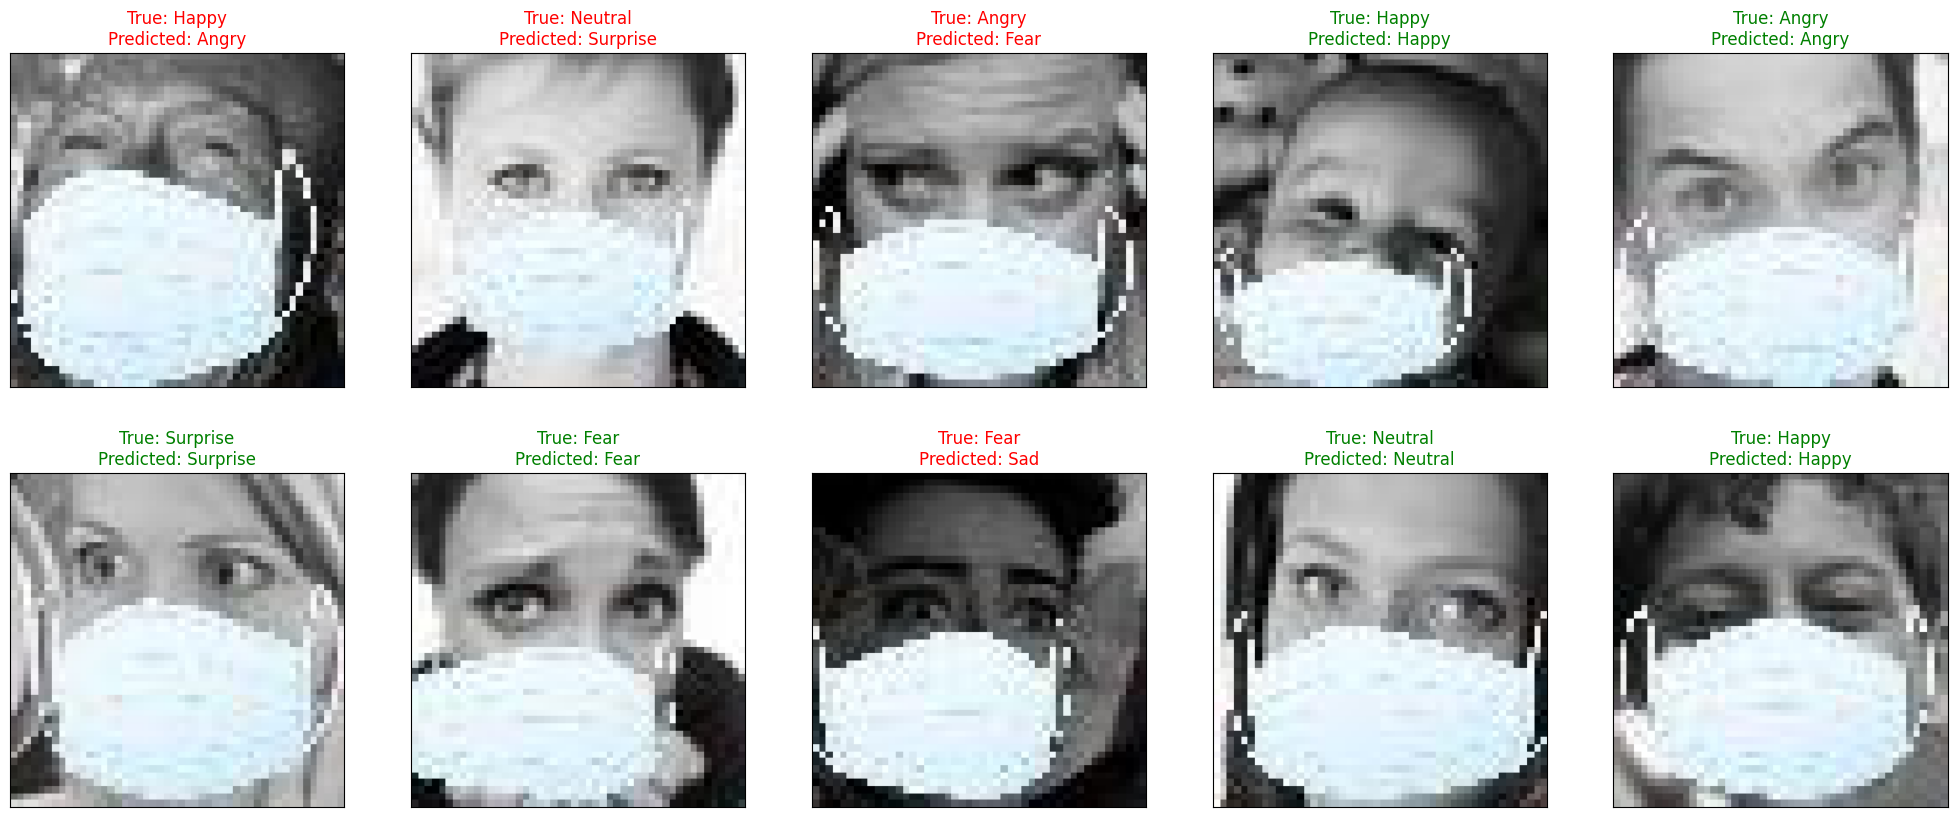

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


### INCEPTION V3

In [ ]:
img_shape = 299
batch_size = 64
data_path = '/content/drive/MyDrive/data_path'

train_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/train')
test_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/validation')

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 15531 images belonging to 7 classes.
Found 4953 images belonging to 7 classes.


In [ ]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Flatten, Dense

def Create_InceptionV3_Model():
    # Load the pre-trained InceptionV3 model without the top (fully connected) layers
    pretrained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    return model


In [ ]:
InceptionV3_Model = Create_InceptionV3_Model()

InceptionV3_Model.summary()

InceptionV3_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 131072)            0         
                                                                 
 dense_14 (Dense)            (None, 256)               33554688  
                                                                 
 batch_normalization_117 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_23 (Dropout)        (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 7)                 

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "InceptionV3_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
InceptionV3__history = InceptionV3_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
242/242 [==============================] - 347s 1s/step - loss: 2.1848 - accuracy: 0.1651 - val_loss: 133.6292 - val_accuracy: 0.2364 - lr: 0.0010
Epoch 2/20
242/242 [==============================] - 301s 1s/step - loss: 2.0015 - accuracy: 0.1703 - val_loss: 23.6983 - val_accuracy: 0.1727 - lr: 0.0010
Epoch 3/20
242/242 [==============================] - 301s 1s/step - loss: 2.0008 - accuracy: 0.1636 - val_loss: 6.4214 - val_accuracy: 0.1297 - lr: 0.0010
Epoch 4/20
242/242 [==============================] - 300s 1s/step - loss: 1.9825 - accuracy: 0.1715 - val_loss: 2.9570 - val_accuracy: 0.1345 - lr: 0.0010
Epoch 5/20
242/242 [==============================] - 301s 1s/step - loss: 1.9256 - accuracy: 0.1913 - val_loss: 16.8624 - val_accuracy: 0.1662 - lr: 0.0010
Epoch 6/20
224/242 [==========================>...] - ETA: 21s - loss: 1.9140 - accuracy: 0.1815

KeyboardInterrupt: ignored

### VGG19 FER Dataset

In [ ]:
from keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from keras import Model

In [ ]:
img_shape = 224
batch_size = 64
data_path = '/content/drive/MyDrive/data_path'

train_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/train')
test_dir = os.path.join(data_path, '/content/drive/MyDrive/data_path/masked-fer/validation')

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 15531 images belonging to 7 classes.
Found 4953 images belonging to 7 classes.


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-06-09 21:39:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-09 21:39:49 (78.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Flatten, Dense

def Create_VGG19_Model():
    # Load the pre-trained VGG19 model without the top (fully connected) layers
    pretrained_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    return model


In [ ]:
VGG19_Model = Create_VGG19_Model()

VGG19_Model.summary()

VGG19_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 512)        2048      
 hNormalization)                                                 
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                      

In [ ]:
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Flatten, Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def fine_tune_vgg19(model):
    # Freeze the layers of the pre-trained VGG19 model
    for layer in model.layers[0].layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    # Create Callback Checkpoint
    checkpoint_path = "VGG19_Model_Checkpoint"
    checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

    # Create Early Stopping Callback to monitor the accuracy
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1)

    # Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
    reducing_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

    callbacks = [checkpoint, early_stopping, reducing_lr]
    steps_per_epoch = train_data.n // train_data.batch_size
    validation_steps = test_data.n // test_data.batch_size

    # Train the model
    VGG19_history = model.fit(train_data, validation_data=test_data, epochs=20, batch_size=batch_size,
                              callbacks=callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

    return model, VGG19_history

# Create the VGG19 model
model = Create_VGG19_Model()

# Fine-tune the VGG19 model
fine_tuned_model, VGG19_history = fine_tune_vgg19(model)


Epoch 1/20
242/242 [==============================] - ETA: 0s - loss: 2.5339 - accuracy: 0.2178

242/242 [==============================] - 186s 763ms/step - loss: 2.5339 - accuracy: 0.2178 - val_loss: 1.7513 - val_accuracy: 0.2908 - lr: 0.0010
Epoch 2/20
242/242 [==============================] - ETA: 0s - loss: 2.0037 - accuracy: 0.2593

242/242 [==============================] - 185s 765ms/step - loss: 2.0037 - accuracy: 0.2593 - val_loss: 1.6671 - val_accuracy: 0.3464 - lr: 0.0010
Epoch 3/20
242/242 [==============================] - ETA: 0s - loss: 1.8340 - accuracy: 0.2895

242/242 [==============================] - 187s 773ms/step - loss: 1.8340 - accuracy: 0.2895 - val_loss: 1.6434 - val_accuracy: 0.3612 - lr: 0.0010
Epoch 4/20
242/242 [==============================] - 182s 752ms/step - loss: 1.7597 - accuracy: 0.2972 - val_loss: 1.6443 - val_accuracy: 0.3557 - lr: 0.0010
Epoch 5/20
242/242 [==============================] - ETA: 0s - loss: 1.7291 - accuracy: 0.3084

242/242 [==============================] - 184s 758ms/step - loss: 1.7291 - accuracy: 0.3084 - val_loss: 1.6251 - val_accuracy: 0.3726 - lr: 0.0010
Epoch 6/20
242/242 [==============================] - 182s 750ms/step - loss: 1.7029 - accuracy: 0.3210 - val_loss: 1.6276 - val_accuracy: 0.3620 - lr: 0.0010
Epoch 7/20
242/242 [==============================] - ETA: 0s - loss: 1.6839 - accuracy: 0.3258
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
242/242 [==============================] - 181s 749ms/step - loss: 1.6839 - accuracy: 0.3258 - val_loss: 1.6283 - val_accuracy: 0.3578 - lr: 0.0010
Epoch 8/20
242/242 [==============================] - 180s 745ms/step - loss: 1.6846 - accuracy: 0.3266 - val_loss: 1.6190 - val_accuracy: 0.3675 - lr: 2.0000e-04
Epoch 9/20
242/242 [==============================] - 181s 749ms/step - loss: 1.6744 - accuracy: 0.3307 - val_loss: 1.6099 - val_accuracy: 0.3699 - lr: 2.0000e-04
Epoch 10/20
242/242 [=========================

242/242 [==============================] - 187s 773ms/step - loss: 1.6729 - accuracy: 0.3347 - val_loss: 1.6055 - val_accuracy: 0.3744 - lr: 2.0000e-04
Epoch 11/20
242/242 [==============================] - 183s 756ms/step - loss: 1.6675 - accuracy: 0.3312 - val_loss: 1.6080 - val_accuracy: 0.3728 - lr: 2.0000e-04
Epoch 12/20
242/242 [==============================] - ETA: 0s - loss: 1.6669 - accuracy: 0.3278
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
242/242 [==============================] - 184s 760ms/step - loss: 1.6669 - accuracy: 0.3278 - val_loss: 1.6066 - val_accuracy: 0.3736 - lr: 2.0000e-04
Epoch 13/20
242/242 [==============================] - 181s 750ms/step - loss: 1.6625 - accuracy: 0.3405 - val_loss: 1.6058 - val_accuracy: 0.3726 - lr: 4.0000e-05
Epoch 14/20
242/242 [==============================] - 180s 746ms/step - loss: 1.6617 - accuracy: 0.3380 - val_loss: 1.6053 - val_accuracy: 0.3726 - lr: 4.0000e-05
Epoch 15/20
242/242 [========

In [ ]:
VGG19_Score = fine_tuned_model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(VGG19_Score[0]))
print("Test Accuracy: {:.2f}%".format(VGG19_Score[1] * 100))

78/78 [==============================] - 11s 144ms/step - loss: 1.6045 - accuracy: 0.3751
    Test Loss: 1.60448
Test Accuracy: 37.51%


In [ ]:
def plot_model(history):

    epochs = range(len(history.history["loss"]))

    # Plot the training and validation loss
    plt.figure(figsize=(15,5))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss VGG19')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy VGG19')
    plt.legend()
    plt.show()


None


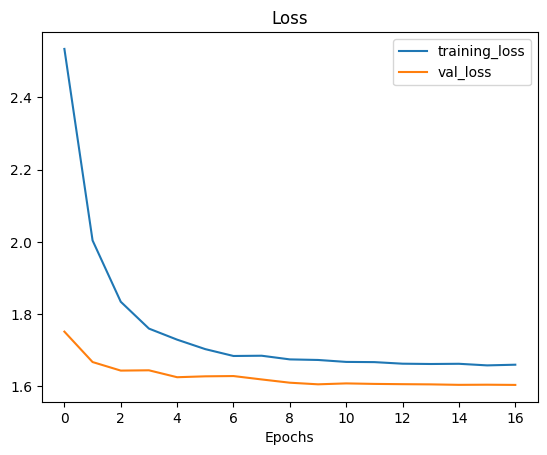

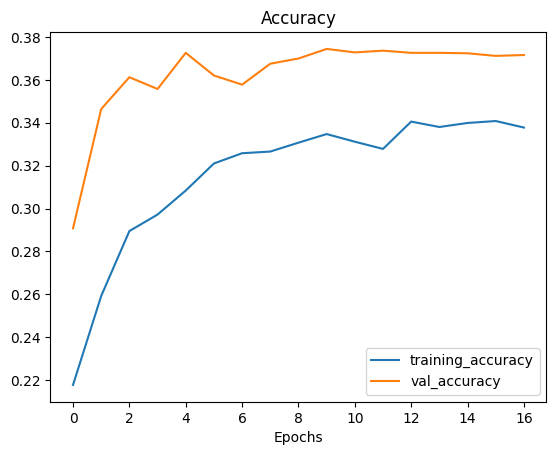

In [ ]:
print(plot_loss_curves(VGG19_history))

In [ ]:
VGG19_Predictions = fine_tuned_model.predict(test_data)

# Choosing highest probalbilty class in every prediction
VGG19_Predictions = np.argmax(ResNet50_Predictions, axis=1)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 10))

class_names = test_data.class_indices

cm = confusion_matrix(test_data.labels, VGG19_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xticklabels(class_names, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

plt.show()

In [ ]:
# Print classification report and confusion matrix

target_names = test_data.class_indices
print('Classification report:')
print(classification_report(test_data.labels, VGG19_Predictions, target_names=target_names))


In [ ]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)


In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "VGG19_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
VGG19_history = fine_tuned_model.fit(train_data ,validation_data = test_data , epochs=15, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/15
 32/242 [==>...........................] - ETA: 2:24 - loss: 3.0755 - accuracy: 0.1484

KeyboardInterrupt: ignored

## LFW Dataset

*** ***

### General CNN Architecture

In [ ]:
image_shape=48
batch_size= 64
LFW_path='/content/drive/MyDrive/LFWMask'

train_path='/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train'
eval_path= '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/eval'


In [ ]:
#Data Augmentation

# Define data augmentation parameters

train_gen = ImageDataGenerator(
        rescale = 1 / 255.,
        # Data Augmentation
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_gen = ImageDataGenerator(
    rescale = 1 / 255.,
)



train_data = train_gen.flow_from_directory(
    train_path,
    class_mode="categorical",
    target_size=(image_shape,image_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)


test_data = test_gen.flow_from_directory(
    eval_path,
    class_mode="categorical",
    target_size=(image_shape,image_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 9825 images belonging to 3 classes.
Found 1213 images belonging to 3 classes.


Found 9825 images belonging to 3 classes.


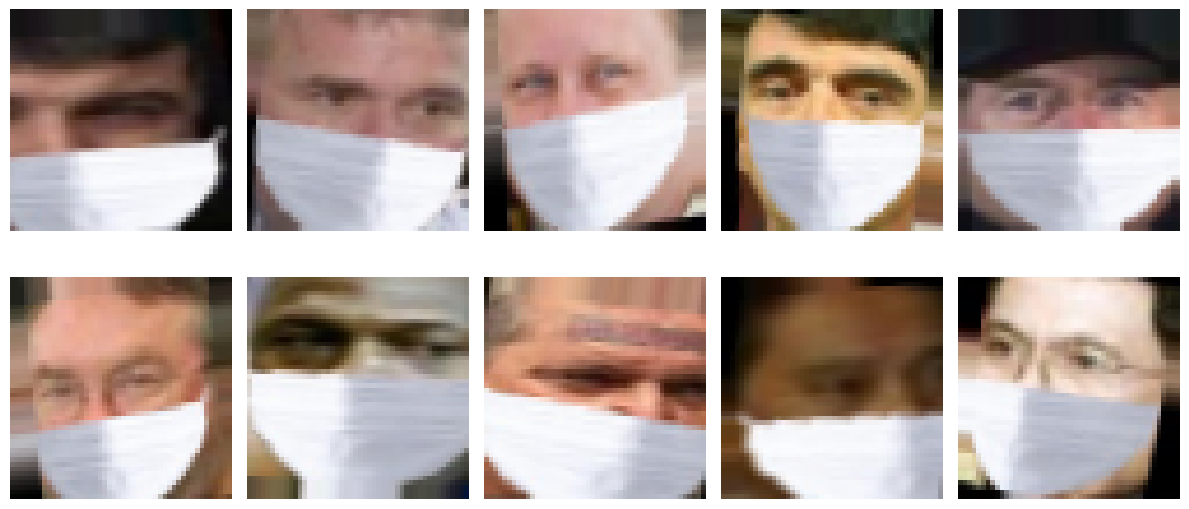

In [ ]:
import matplotlib.pyplot as plt

# Generate augmented images
augmented_images = train_datagen.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

# Visualize augmented images
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
axs = axs.ravel()

for i in range(10):
    image = augmented_images.next()[0][0]  # Get the first augmented image
    axs[i].imshow(image)
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
#4 convolutional layer
from keras.layers import BatchNormalization

def CNN_model():
    model = Sequential()

    model.add(Conv2D(64, (3,3), activation='relu', input_shape=(image_shape, image_shape, 3)))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(512, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(3, activation='softmax'))

    return model


In [ ]:
CNN_Model = CNN_model()
CNN_Model.summary()
CNN_Model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 128)      0

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "CNN_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
CNN_history = CNN_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
153/153 [==============================] - 1442s 9s/step - loss: 1.3584 - accuracy: 0.4499 - val_loss: 2.2245 - val_accuracy: 0.5339 - lr: 0.0010
Epoch 2/20
153/153 [==============================] - 24s 154ms/step - loss: 1.0458 - accuracy: 0.5009 - val_loss: 1.6536 - val_accuracy: 0.5339 - lr: 0.0010
Epoch 3/20
153/153 [==============================] - 23s 152ms/step - loss: 0.9588 - accuracy: 0.5216 - val_loss: 1.0333 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 4/20
153/153 [==============================] - 23s 153ms/step - loss: 0.9282 - accuracy: 0.5339 - val_loss: 0.9831 - val_accuracy: 0.5347 - lr: 0.0010
Epoch 5/20
153/153 [==============================] - 24s 154ms/step - loss: 0.9046 - accuracy: 0.5480 - val_loss: 0.9372 - val_accuracy: 0.5339 - lr: 0.0010
Epoch 6/20
153/153 [==============================] - 23s 152ms/step - loss: 0.8952 - accuracy: 0.5541 - val_loss: 0.9497 - val_accuracy: 0.4028 - lr: 0.0010
Epoch 7/20
153/153 [==============================] -

In [ ]:
CNN_Score = CNN_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(CNN_Score[0]))
print("Test Accuracy: {:.2f}%".format(CNN_Score[1] * 100))

19/19 [==============================] - 2s 92ms/step - loss: 0.8328 - accuracy: 0.5738
    Test Loss: 0.83279
Test Accuracy: 57.38%


In [ ]:
def plot_model(history):

    epochs = range(len(history.history["loss"]))

    # Plot the training and validation loss
    plt.figure(figsize=(15,5))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()


<Figure size 1500x500 with 0 Axes>

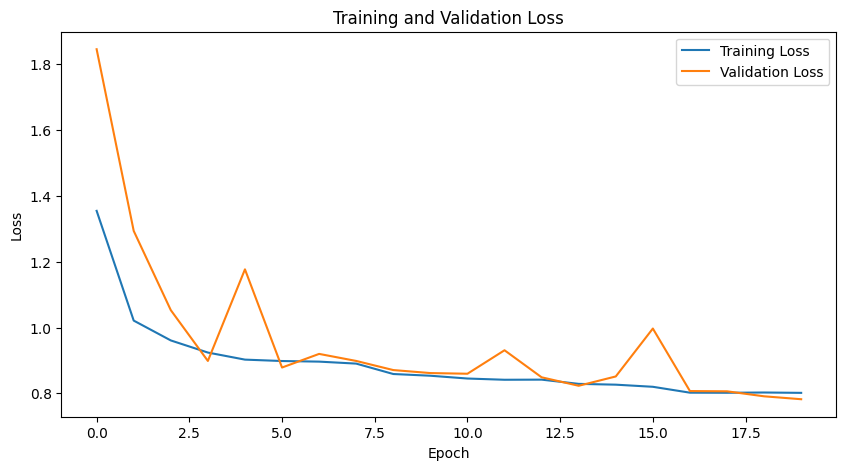

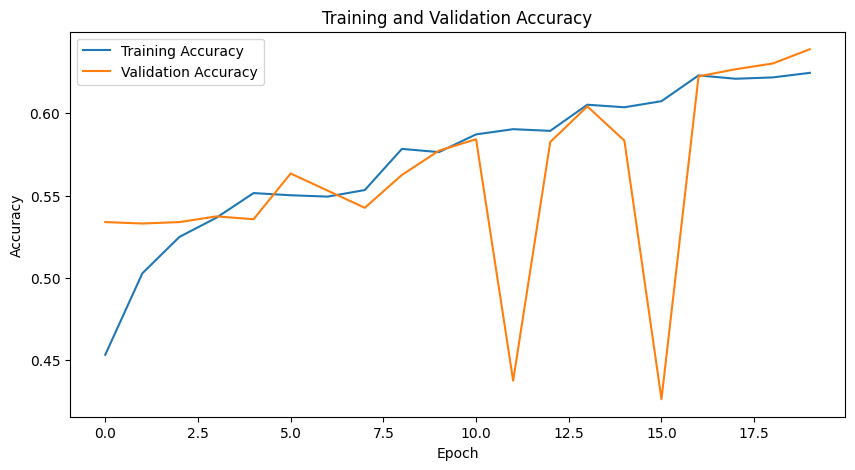

None


In [ ]:
print(plot_model(CNN_history))

In [ ]:
CNN_Predictions = CNN_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
CNN_Predictions = np.argmax(CNN_Predictions, axis=1)

19/19 [==============================] - 3s 149ms/step


Text(0.5, 1.0, 'CNN Confusion Matrix')

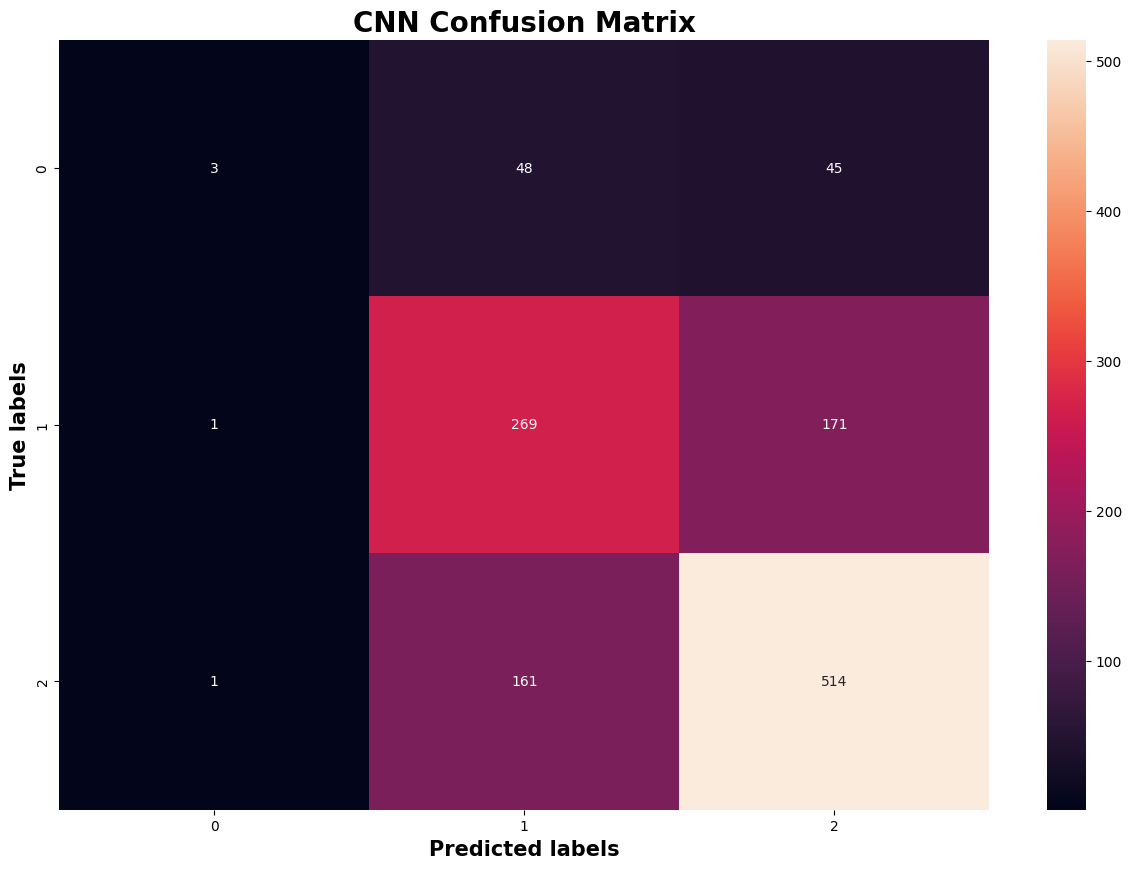

In [ ]:
import seaborn as sns
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, CNN_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('CNN Confusion Matrix', fontsize=20, fontweight='bold')

In [ ]:
test_data.class_indices

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
# Print classification report and confusion matrix
print('Classification report:')
print(classification_report(test_data.labels, CNN_Predictions))

Classification report:
              precision    recall  f1-score   support

           0       0.60      0.03      0.06        96
           1       0.56      0.61      0.59       441
           2       0.70      0.76      0.73       676

    accuracy                           0.65      1213
   macro avg       0.62      0.47      0.46      1213
weighted avg       0.64      0.65      0.63      1213



In [ ]:
Emotion_Classes = ['negative',
                  'neutral',
                  'positive']


In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    eval_path,
    class_mode="categorical",
    target_size=(image_shape,image_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 1213 images belonging to 3 classes.


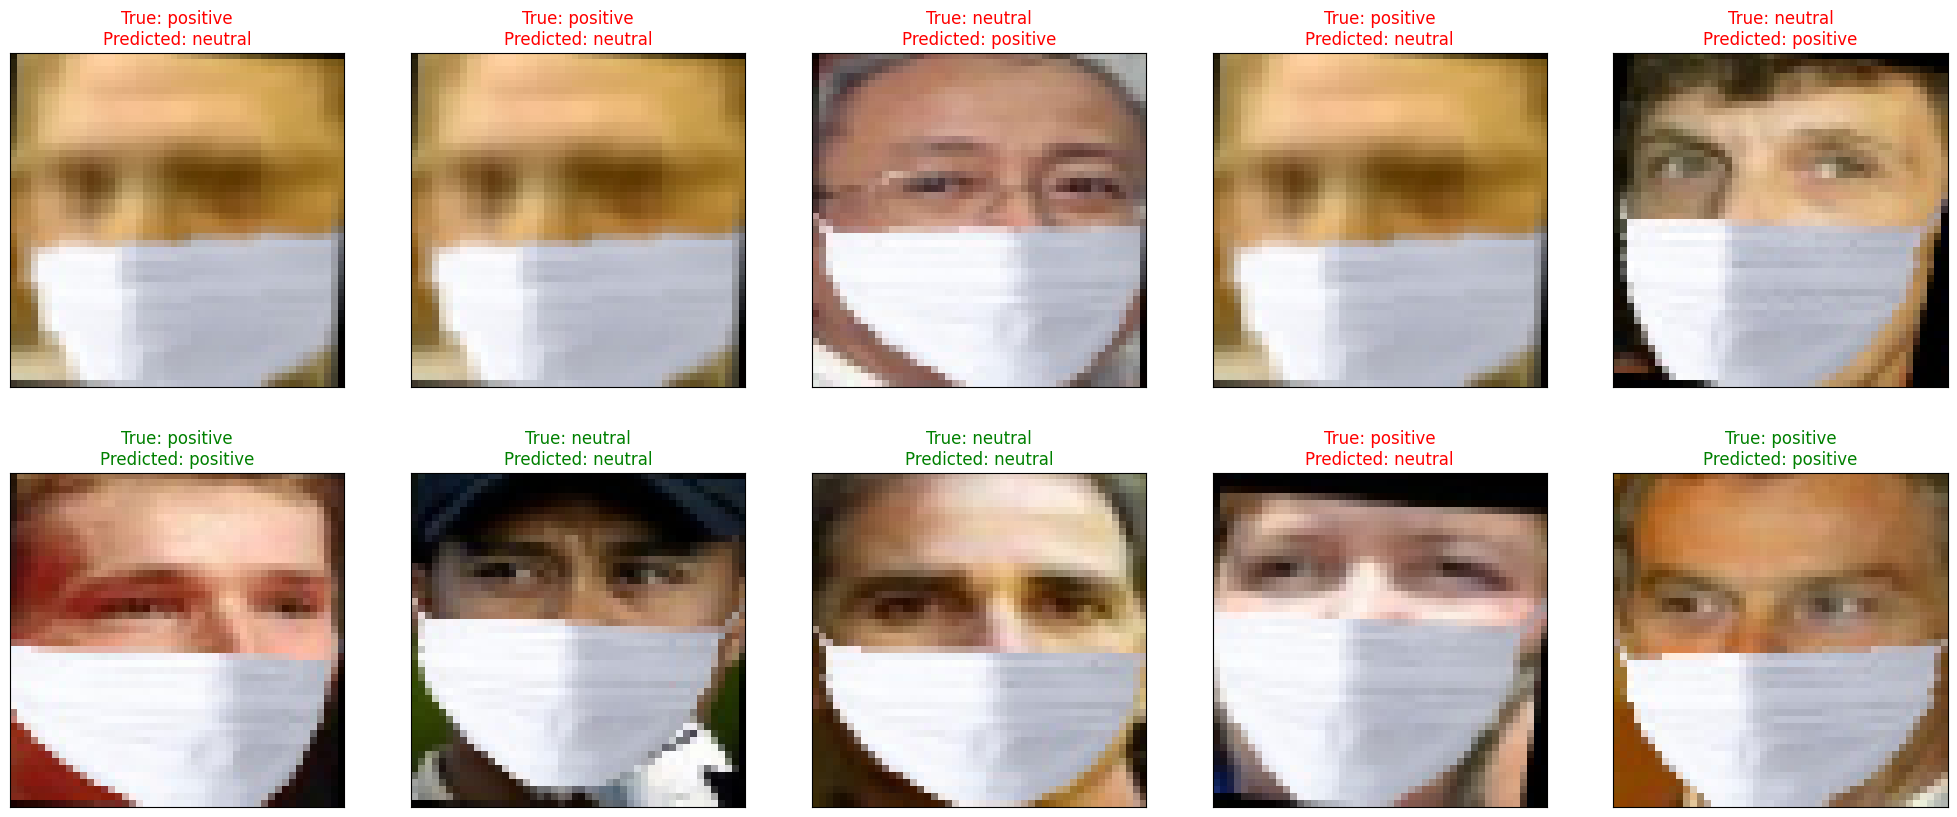

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(CNN_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


### RESNET50 LFW Dataset

In [ ]:
img_shape = 224
batch_size = 64
data_path = '/content/drive/MyDrive/LFWMask'

train_dir = os.path.join(data_path, '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train')
test_dir = os.path.join(data_path, '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/eval')

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 9825 images belonging to 3 classes.
Found 1213 images belonging to 3 classes.


In [ ]:
# Fine-Tuning ResNet50V2
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
from keras.layers import BatchNormalization

def Create_ResNet50V2_Model():
    model = Sequential([
                      ResNet50V2,
                      Dropout(.5),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(3,activation='softmax')
                    ])
    return model

In [ ]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 7, 7, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_3 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_7 (Batc  (None, 64)               256       
 hNormalization)                                      

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
153/153 [==============================] - 129s 762ms/step - loss: 1.0840 - accuracy: 0.5935 - val_loss: 43.1909 - val_accuracy: 0.5304 - lr: 0.0010
Epoch 2/20
153/153 [==============================] - 115s 751ms/step - loss: 0.8824 - accuracy: 0.6677 - val_loss: 3.7483 - val_accuracy: 0.5425 - lr: 0.0010
Epoch 3/20
153/153 [==============================] - 116s 759ms/step - loss: 0.7490 - accuracy: 0.6894 - val_loss: 1.9893 - val_accuracy: 0.6345 - lr: 0.0010
Epoch 4/20
153/153 [==============================] - 115s 751ms/step - loss: 0.6786 - accuracy: 0.7113 - val_loss: 0.7416 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 5/20
153/153 [==============================] - 115s 749ms/step - loss: 0.6510 - accuracy: 0.7209 - val_loss: 0.7652 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 6/20
153/153 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.7271
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
153/153 [======================

In [ ]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

19/19 [==============================] - 3s 175ms/step - loss: 0.6465 - accuracy: 0.7362
    Test Loss: 0.64647
Test Accuracy: 73.62%


In [ ]:
def plot_model(history):

    epochs = range(len(history.history["loss"]))

    # Plot the training and validation loss
    plt.figure(figsize=(15,5))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss ResNet50V2 LFW')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy ResNet50V2 LFW')
    plt.legend()
    plt.show()


<Figure size 1500x500 with 0 Axes>

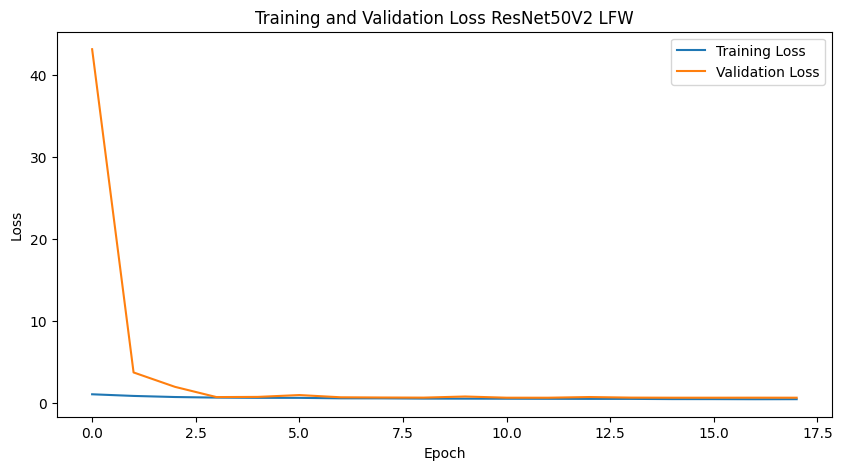

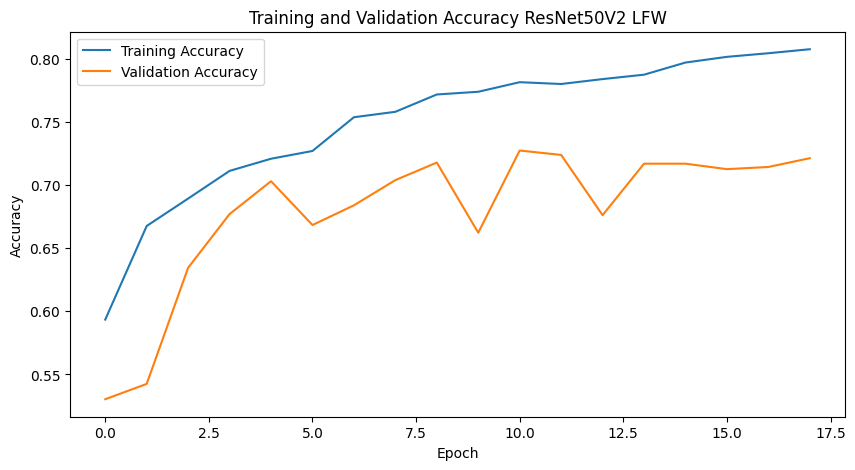

None


In [ ]:
print(plot_model(ResNet50V2_history))

In [ ]:
ResNet50_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50_Predictions = np.argmax(ResNet50_Predictions, axis=1)

19/19 [==============================] - 4s 156ms/step


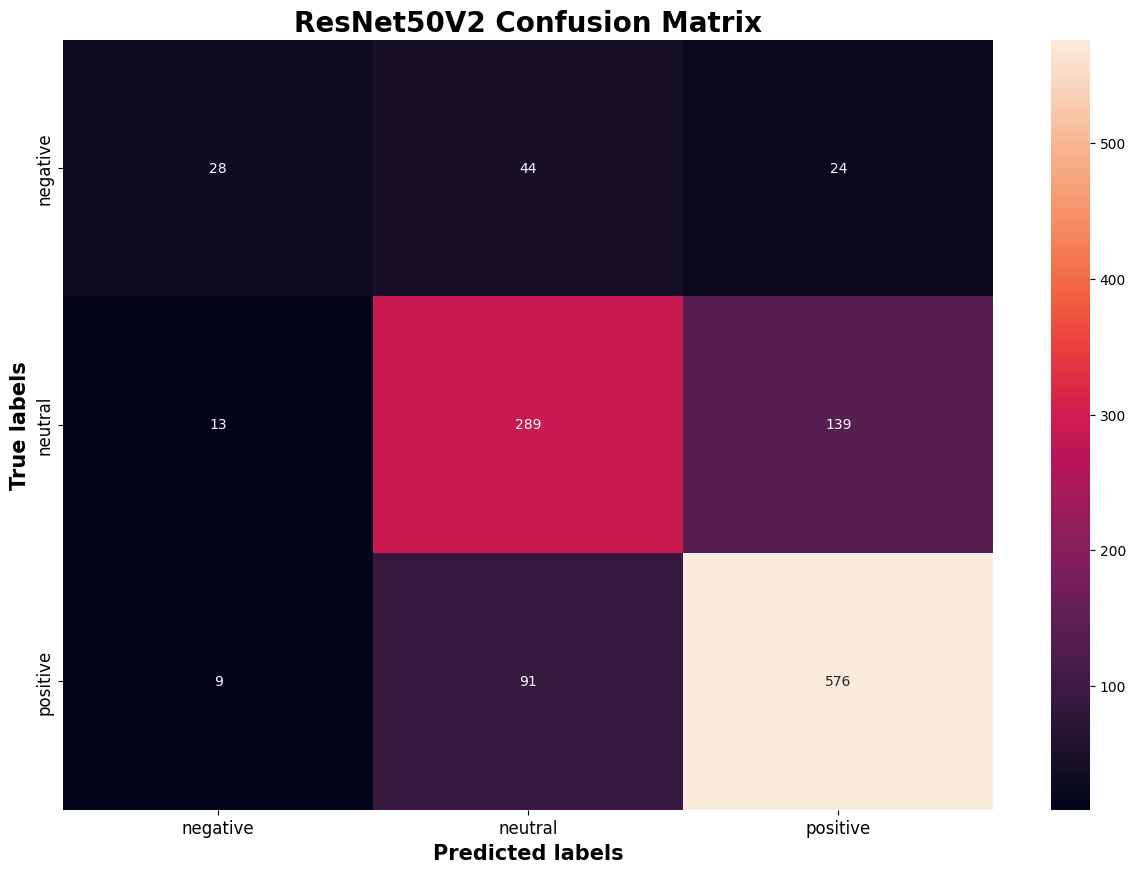

Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix LFW')

In [ ]:
import seaborn as sns
fig , ax= plt.subplots(figsize=(15,10))

class_names = test_data.class_indices

cm = confusion_matrix(test_data.labels, ResNet50_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xticklabels(class_names, fontsize=12)
ax.set_yticklabels(class_names, fontsize=12)

ax.set_xlabel('Predicted labels', fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

plt.show()

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix LFW', fontsize=20, fontweight='bold')

In [ ]:
test_data.class_indices

{'negative': 0, 'neutral': 1, 'positive': 2}

In [ ]:
# Print classification report and confusion matrix
print('Classification report:')
target_names = test_data.class_indices
print(classification_report(test_data.labels, ResNet50_Predictions, target_names=target_names))

Classification report:
              precision    recall  f1-score   support

    negative       0.56      0.29      0.38        96
     neutral       0.68      0.66      0.67       441
    positive       0.78      0.85      0.81       676

    accuracy                           0.74      1213
   macro avg       0.67      0.60      0.62      1213
weighted avg       0.73      0.74      0.73      1213



In [ ]:
Emotion_Classes = ['negative',
                  'neutral',
                  'positive']

In [ ]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 1213 images belonging to 3 classes.


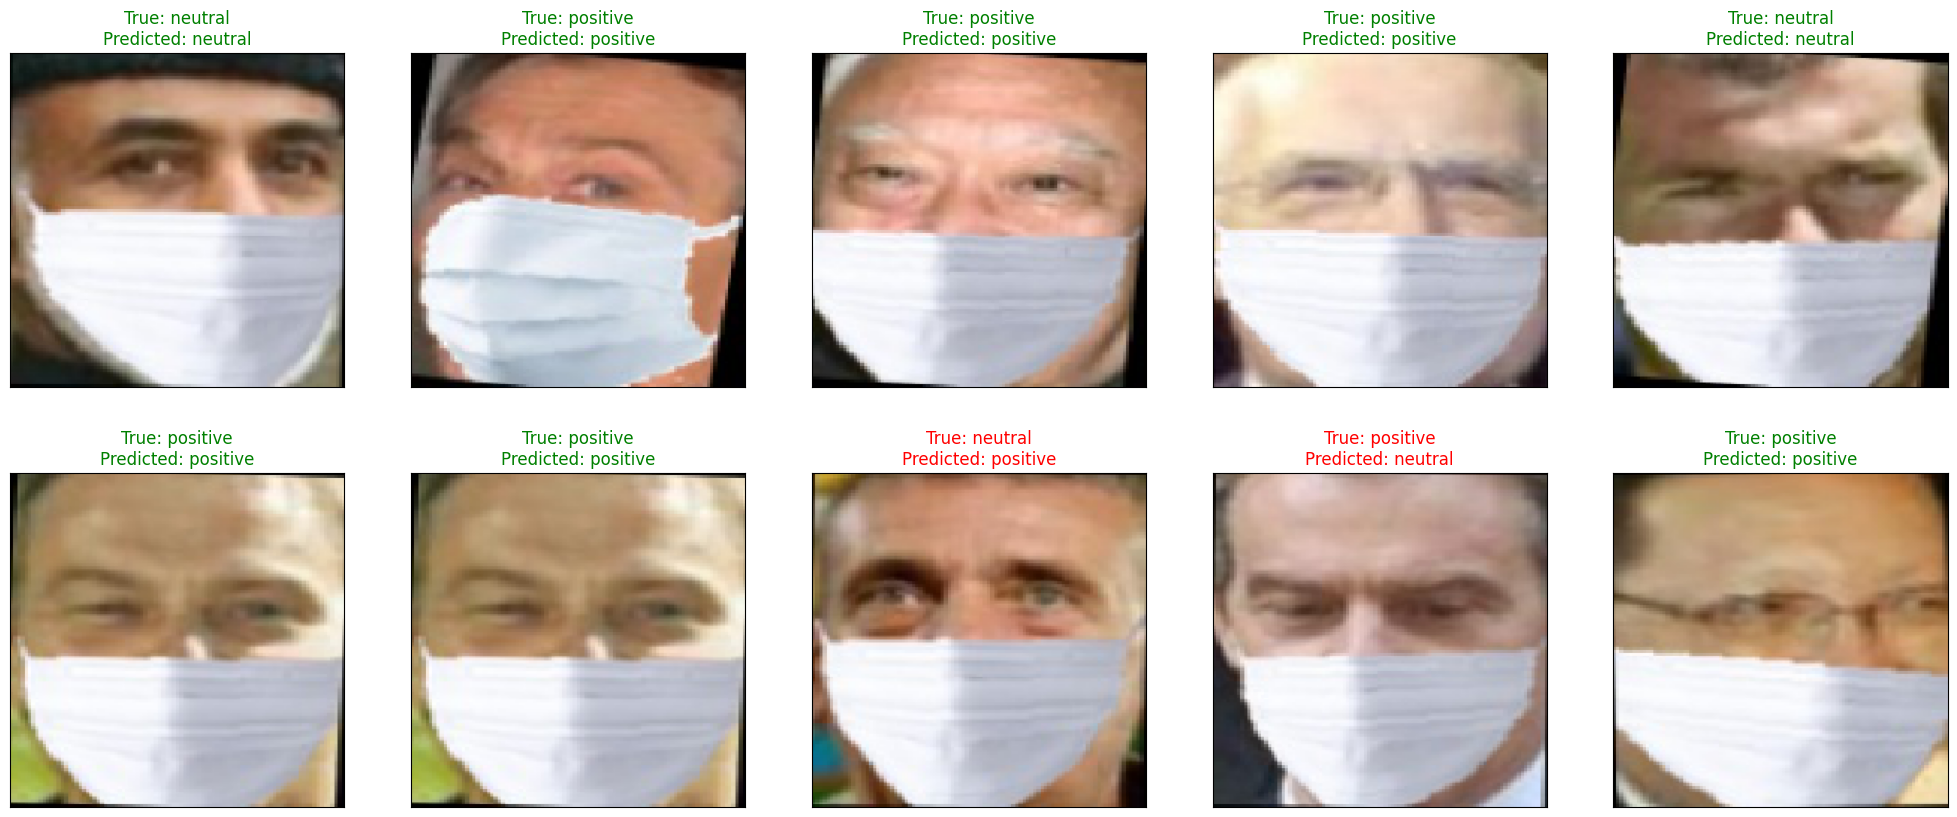

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()


### VGG19 LFW Dataset

In [ ]:
img_shape = 224
batch_size = 64
LFW_path='/content/drive/MyDrive/LFWMask'

train_path='/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train'
eval_path= '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/eval'

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    eval_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 9825 images belonging to 3 classes.
Found 1213 images belonging to 3 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Flatten, Dense

def Create_VGG19_Model():
    model = Sequential([
        pretrained_model,
        Dropout(0.5),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    return model

In [ ]:
VGG19_Model = Create_VGG19_Model()

VGG19_Model.summary()

VGG19_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                        

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "VGG19_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning rate
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.000005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
VGG19_history = VGG19_Model.fit(train_data , validation_data= test_data,
                            epochs=20, batch_size= batch_size,
                            callbacks=callbacks,
                            steps_per_epoch= steps_per_epoch,
                            validation_steps=validation_steps)

NameError: ignored

### INCEPTION19

In [ ]:
img_shape = 299
batch_size = 64
data_path = '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut'

train_dir = os.path.join(data_path, '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/train')
test_dir = os.path.join(data_path, '/content/drive/MyDrive/LFWMask/M-LFW-FER-face-cut/eval')

In [ ]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)

test_data = test_preprocessor.flow_from_directory(
    test_dir,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 9825 images belonging to 3 classes.
Found 1213 images belonging to 3 classes.


In [ ]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dropout, BatchNormalization, Flatten, Dense

def Create_InceptionV3_Model():
    # Load the pre-trained InceptionV3 model without the top (fully connected) layers
    pretrained_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    return model


In [ ]:
InceptionV3_Model = Create_InceptionV3_Model()

InceptionV3_Model.summary()

InceptionV3_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 256)               33554688  
                                                                 
 batch_normalization_379 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 771       
                                                      

In [ ]:
InceptionV3_Model = Create_InceptionV3_Model()

InceptionV3_Model.summary()

InceptionV3_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 131072)            0         
                                                                 
 dense_8 (Dense)             (None, 256)               33554688  
                                                                 
 batch_normalization_474 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 771       
                                                      

In [ ]:
# Create Callback Checkpoint
checkpoint_path = "InceptionV3_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [ ]:
InceptionV3__history = InceptionV3_Model.fit(train_data ,validation_data = test_data , epochs=20, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/20
153/153 [==============================] - 12099s 79s/step - loss: 1.1654 - accuracy: 0.5079 - val_loss: 3449.1379 - val_accuracy: 0.5356 - lr: 0.0010
Epoch 2/20
 25/153 [===>..........................] - ETA: 2:43:52 - loss: 0.9980 - accuracy: 0.5656

# AffecNet

## VGG19

### Inception V3


In [ ]:
img_shape = 299
batch_size = 64
data_path = '/kaggle/input/fer2013'

train_dir = os.path.join(data_path, '/kaggle/input/fer2013/train')
test_dir = os.path.join(data_path, '/kaggle/input/fer2013/test')